Gerekli kütüphaneleri import ediyoruz.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

pandas kütühanesini kullanarak veri setimizi okuyalım.

In [6]:
dataset = pd.read_csv('news_articles.csv')
dataset.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


12 columndan oluşan bir verisetimiz varmış ve bunun ilk 5 elemanını gözlemledik.

In [7]:
dataset['type'].unique()

array(['bias', 'conspiracy', 'fake', 'bs', 'satire', 'hate', 'junksci',
       'state', nan], dtype=object)

In [8]:
dataset.info()
dataset.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2096 non-null   object 
 1   published                2096 non-null   object 
 2   title                    2096 non-null   object 
 3   text                     2050 non-null   object 
 4   language                 2095 non-null   object 
 5   site_url                 2095 non-null   object 
 6   main_img_url             2095 non-null   object 
 7   type                     2095 non-null   object 
 8   label                    2095 non-null   object 
 9   title_without_stopwords  2094 non-null   object 
 10  text_without_stopwords   2046 non-null   object 
 11  hasImage                 2095 non-null   float64
dtypes: float64(1), object(11)
memory usage: 196.6+ KB


author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

bazı columnlarda null değerler olduğunu gördük ve bu null değerleri temizlemeliyiz.

In [9]:
dataset.dropna(inplace=True)
dataset.isna().sum()

author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
main_img_url               0
type                       0
label                      0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
dtype: int64

veri setinde bulunan haberlerin gerçek ve sahte olarak yüzdelerini görselleştirelim.

In [10]:
fig = px.pie(dataset,names='label',title='Proportion of Real vs. Fake News')
fig.show()

Type columnunu görselleştirerek inceleyelim. Hangi çeşit yazıların bulunduğunu ve oranlarını görelim.

In [11]:
fig = px.pie(dataset,names='type',title='Types of Articles')
fig.show()


8 çeşit yazımız varmış bunlar:
-bias
-conspiracy
-fake
-bs 
-satire
-hate
-junksci
-state
-(!eğer null verileri temizlemeseydik bu görsel de null diye bir çeşitte görecektik!)

mathplotlib yardımıyla language columnunu sütun grafiğine dökerek haberlerin hangi dillerde yazıldığını inceleyebiliriz.

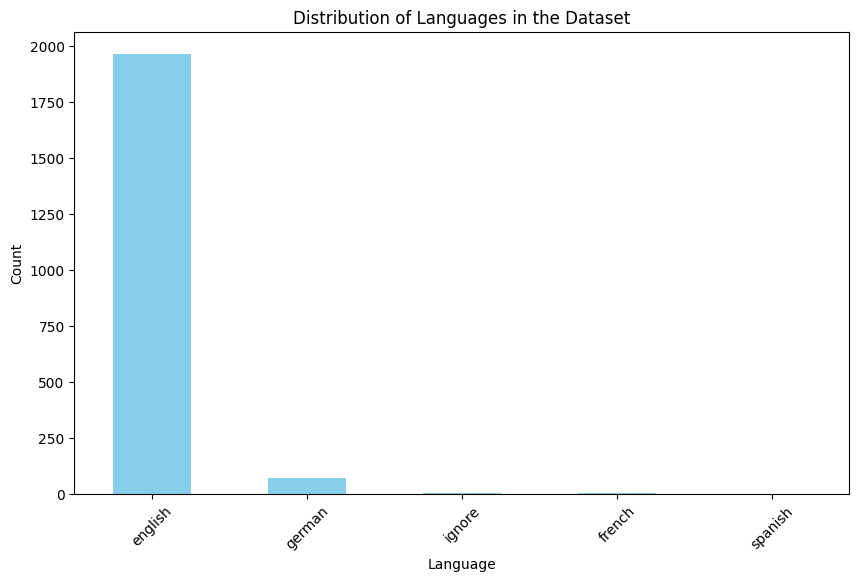

In [12]:
language_counts = dataset['language'].value_counts()

plt.figure(figsize=(10,6))
language_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Languages in the Dataset')
plt.xlabel('Language')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


En çok haber yayınlayan siteler.

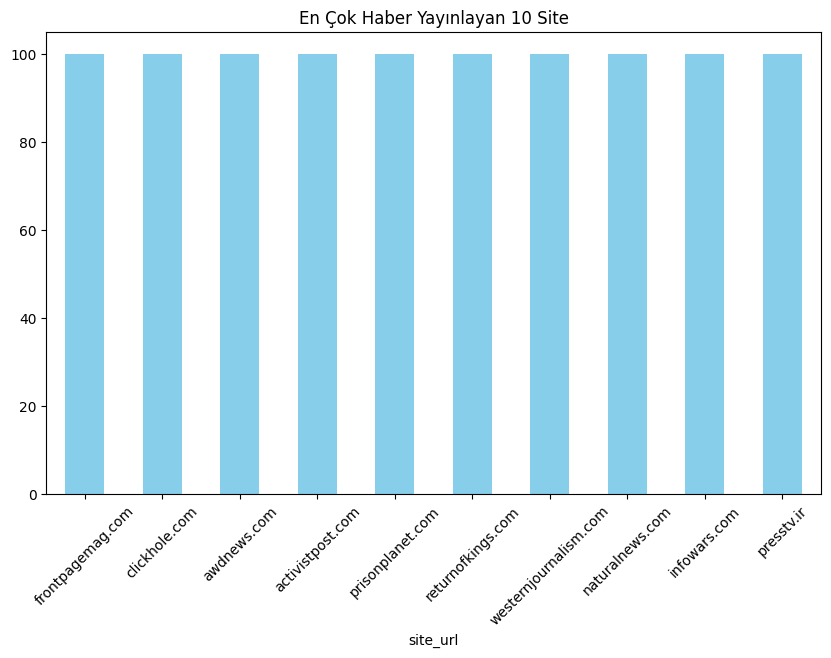

In [13]:
plt.figure(figsize=(10,6))
dataset['site_url'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title("En Çok Haber Yayınlayan 10 Site")
plt.xticks(rotation=45)
plt.show()


Sahte haberlerin içerdiği kelimelerle ilgili bir kelime bulutu.

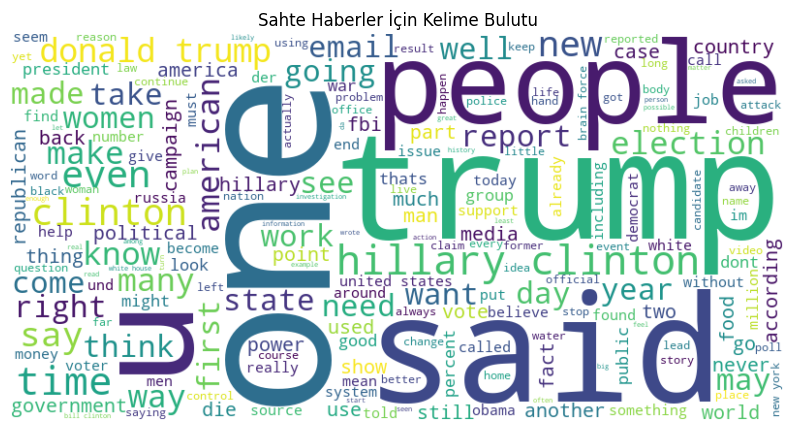

In [14]:
from wordcloud import WordCloud
fake_text = ' '.join(dataset.loc[dataset['label'] == 'Fake', 'text_without_stopwords'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Sahte Haberler İçin Kelime Bulutu")
plt.show()

Keşifsel veri analizimizi yaptık artık supervised ve unsupervised algoritmalarını uygulayarak aynı veri seti üzerinde iki model eğitmeliyiz. İlk olarak veri setimi features ve target olarak ikiye ayırıcam. Modeli eğitmek için site_url , text_without_stopwords,title,language ve author columnları kullanıcam. Modelin amacı bu featureları kullanarak haberin gerçek veya sahte olduğunu tahmin etmesi.

In [15]:
x = dataset.loc[:,['site_url','text_without_stopwords','title','author','language','main_img_url']]
y = dataset.loc[:,'label']
print(dataset.columns)


Index(['author', 'published', 'title', 'text', 'language', 'site_url',
       'main_img_url', 'type', 'label', 'title_without_stopwords',
       'text_without_stopwords', 'hasImage'],
      dtype='object')


Veri setim textlerden oluştuğu için bunları sayısal değerlere çevirmeliyim.Bunun için label encoder ve tfidvectorizer kullanıcam.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
y = encoder.fit_transform(y)

tfidf_img_url = TfidfVectorizer(stop_words='english')
tfidf_site_url = TfidfVectorizer(stop_words='english')
tfidf_text = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_title = TfidfVectorizer(stop_words='english')
tfidf_language =TfidfVectorizer(stop_words='english')
tfidf_author = TfidfVectorizer(stop_words='english')

tfidf_author_matrix = tfidf_author.fit_transform(x['author'])
tfidf_language_matrix = tfidf_language.fit_transform(x['language'])
tfidf_site_url_matrix = tfidf_site_url.fit_transform(x['site_url'])
tfidf_text_matrix = tfidf_text.fit_transform(x['text_without_stopwords'])
tfidf_title_matrix = tfidf_title.fit_transform(x['title'])
tfidf_img_url_matrix = tfidf_img_url.fit_transform(x['main_img_url'])

# Özelliklerin birleştirilmesi
X_combined = hstack([tfidf_site_url_matrix, tfidf_text_matrix, tfidf_title_matrix,tfidf_author_matrix,tfidf_language_matrix,tfidf_img_url_matrix])
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3,random_state=42)


Üstteki kodda ayrı ayrı tüm featureları sayısal vektörlere dönüştürdüm ve hstack ile featureları birbirine bağlayıp tek bir vektöre indirgedim bunun sebebi daha sonra kullanıcağım kmeans algoritmasında featurelarımın hepsini bir kerede atıp gruplandırılmasını sağlamak.Diğer yandan modelim için kullanacağım diğer algoritma ise logistic regression olduğundan veri setimi test ve train datası olarak böldüm.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(X_train,y_train)
logistic_reg_predict = logistic_reg_model.predict(X_test)

kmeans_model = KMeans(n_clusters=2,random_state=42)
kmeans_model.fit(X_combined)
kmeans_clusters = kmeans_model.predict(X_combined)

logistic regression ve kmeans olarak iki ayrı model eğittik. Sırada bu modellerin performanslarını incelemek var.Önce logistic regression modelinin performansını inceleyelim.

In [18]:
from sklearn.metrics import confusion_matrix , accuracy_score ,classification_report, mean_squared_error
from numpy import sqrt

rmse = sqrt(mean_squared_error(y_test,logistic_reg_predict))
logistic_conf_mat = confusion_matrix(y_test,logistic_reg_predict)
logistic_accuracy = accuracy_score(y_test,logistic_reg_predict)
logistic_report = classification_report(y_test,logistic_reg_predict)

print('confussion matrix of logistic regression model:\n',logistic_conf_mat)
print('accuracy score =',logistic_accuracy)
print('rmse = ',rmse)
print(logistic_report)

confussion matrix of logistic regression model:
 [[405   0]
 [  1 208]]
accuracy score = 0.998371335504886
rmse =  0.040356715613563084
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       1.00      1.00      1.00       209

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



Modelimizin performansına baktığımızda modelin gayet iyi çalıştığını görebiliyoruz. Confussion matriximize göre TN ve TP veriler FN ve FP den fazla. Accuracy score'a bakarsak 1'e çok yakın olduğunu ve model için iyi bir performans gösterdiğini söyleyebiliriz.

kmeans modelin performansını ölçmek için silhouette score kullanıcaz. Başta küme sayımı 2 oalrak belirlemiştim ancak en iyi performans için küme sayısını tespit etmeliyiz.Bunun için bir for loopu kullanarak her küme sayısı için silhouette score hesaplarız.

In [19]:
#k_means modelinin her küme içerisinde kaç veri barındırdığını görebiliriz.
np.unique(kmeans_clusters,return_counts=True)

from sklearn.metrics import silhouette_score
silhouettes = []
ks = list(range(2,12))

for n_cluster in ks:
    kmeans = KMeans(n_clusters=n_cluster).fit(X_combined)
    kmeans_clusters = kmeans.labels_
    sil_coef = silhouette_score(X_combined,kmeans_clusters)
    print('for n_clusters = {},the silhouette is{}'.format(n_cluster,sil_coef))
    silhouettes.append(sil_coef)

for n_clusters = 2,the silhouette is0.0420025122955939
for n_clusters = 3,the silhouette is0.03804918923178282
for n_clusters = 4,the silhouette is0.0275599769076962
for n_clusters = 5,the silhouette is0.0701861875615964
for n_clusters = 6,the silhouette is0.07760944091908117
for n_clusters = 7,the silhouette is0.06347548138778429
for n_clusters = 8,the silhouette is0.06241166742871483
for n_clusters = 9,the silhouette is0.07588821979567309
for n_clusters = 10,the silhouette is0.08199334701119414
for n_clusters = 11,the silhouette is0.08883961720844466


En iyi silhouette score 1 e yakın olandır ancak değerlere bakrsak küme sayısı 2 ve 12 arasında iken silhouette scorelar 1 e çok uzaklar.Ama yinede en iyi skoru veren küme sayısı 11 olduğunu gördük. kmeans algoritmasında ki n_clusters sayımızı 11 olarak güncellemeliyiz.

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
tfidf_combined_scaled = scaler.fit_transform(X_combined)

kmeans_model = KMeans(n_clusters=11, random_state=42)
kmeans_clusters = kmeans_model.fit_predict(X_combined)
print(silhouette_score(X_combined,kmeans_clusters))


0.09686504751448113


Kmeans modelimizin performansını iyileştirmek amacıyla verilerimizi ölçeklendirdik ve silhouette score'un yükseldiğini gözlemledik.